<a href="https://colab.research.google.com/github/TJSun009/University-Projects/blob/main/Chord_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chord Classifier

## Import fastai and timm Libraries

In [ ]:
!pip install -Uqqq timm fastai
import timm
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

## Image Representation

#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import librosa
import librosa.display
from pathlib import Path

#### Waveform

In [ ]:

# always limit two second sample
def save_waveform(audio_file, dest=''):
    samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

    librosa.display.waveshow(samples, sr=sample_rate)
    
    plt.axis('off')

    path = f"{(dest if dest else audio_file).replace('.wav', '_wave.png')}"
    plt.savefig(path)
    plt.close()
    return path


#### Mel Spectrogram

In [ ]:

def save_mel_spectrogram(audio_file, dest=''):
    # Adapted from https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

    samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

    # std spectogram
    sgram = librosa.stft(samples)

    # use the mel-scale instead of raw frequency
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    
    # use the decibel scale to get the final Mel Spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    librosa.display.specshow(mel_sgram, sr=sample_rate)
    
    plt.axis('off')

    path = f"{(dest if dest else audio_file).replace('.wav', '_spec.png')}"
    plt.savefig(path)
    plt.close()
    return path


#### Chromagrams

In [ ]:
def hps(signal, orig_sr, M = 3):
  # harmoic power spectrum of signal
  # M is number of harmonics to be considered
  # notes
  # each index in the array of signal represents a frequency
  # the value in each is amplitude

  decimated_ys = []

  for i in range(0, M + 1):
    y = librosa.resample(signal, orig_sr=orig_sr, target_sr=(2**i)*orig_sr)
    decimated_ys.append(np.abs(y))
  
  min_length = min([len(a) for a in decimated_ys])

  decimated_ys = [a[:min_length] for a in decimated_ys]
  
  hps = np.prod(decimated_ys, axis = 0)

  peak = np.argmax(hps)

  f0 = hps[peak]

  return hps



In [ ]:
def save_chromagram(audio_file, dest = '', type="stft"):
  samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

  if type == "stft":
    chroma = librosa.feature.chroma_stft(samples)
  elif type == "cqt":
    # looks best at first glance
    chroma = librosa.feature.chroma_cqt(samples)
  elif type == "epcp":
    # params from K Lee
    # sample rate - 11025Hz
    # bins - 36, librosa default
    # window length - 8192
    # hop size - 1024
    # note we are using STFT instead of DFT

    samples, sample_rate = librosa.load(audio_file, duration=2, sr=11025)
    samples = hps(samples, sample_rate)

    chroma = librosa.feature.chroma_cqt(samples, hop_length=1024)

  librosa.display.specshow(chroma, sr=sample_rate, y_axis='chroma', x_axis='time')
  
  plt.axis('off')

  path = f"{(dest if dest else audio_file).replace('.wav', f'_chroma_{type}.png')}"
  plt.savefig(path)
  plt.close()
  return path

#### All Charts

In [ ]:
def save_chart(audio_file, chart, dest = ''):
  for aliases in IMAGE_TYPES:
    if chart in aliases:
      chart = aliases[1]
      break
  
  if chart == "wave":
    return save_waveform(audio_file, dest)
  elif chart == "spec":
    return save_mel_spectrogram(audio_file, dest)
  
  return save_chromagram(audio_file, dest, type=chart)

## Raw Audio

In [ ]:
def load_audio(audio_file):
    # original sample rate used
    
    samples, sample_rate = librosa.load(audio_file, duration=2, sr=None)

    return np.array(samples)

## Image Setup

In [ ]:
FASTAI_ROOT = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai"
IMAGE_ROOT = f"{FASTAI_ROOT}/Lesson_1/images"

IMAGE_TYPES = [
        ["spectogram", "spec", "s"],
        ["waveform", "wave", "w"],
        ["stft_chromagram", "stft", "sc"],
        ["cqt_chromagram","cqt", "cc"],
        ["epcp_chromagram", "epcp", "ec"]
    ]

CHORD_TYPES = ["major", "minor"]

## Retrieve and Transform Data

### Imports

In [ ]:
# Install Kaggle CLI
! pip install -Uqqq kaggle

### Create Image Dirs

In [ ]:
for aliases in IMAGE_TYPES:
  chart = aliases[0]
  for q in CHORD_TYPES:
    Path(f"{IMAGE_ROOT}/{chart}/{q}").mkdir(parents=True, exist_ok=True)

### Retrieve Major, Minor Chord Dataset from Kaggle

In [ ]:
audio_temp = "/content/audio"

In [ ]:
%%bash -s "{FASTAI_ROOT}" {audio_temp}

FASTAI_ROOT=$1;
audio_temp=$2;

mkdir -p ~/.kaggle/;
cp "$FASTAI_ROOT"/kaggle.json ~/.kaggle;
chmod 600 ~/.kaggle/kaggle.json;

# Download and Unzip Wav Files from datasets: 
# https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
# https://www.kaggle.com/datasets/davidbroberts/piano-triads-wavset
if [ ! -f "$FASTAI_ROOT"/audio.zip ]; then
  mkdir "$audio_temp";
  kaggle datasets download -d deepcontractor/musical-instrument-chord-classification;
  unzip -qn musical-instrument-chord-classification "Audio_Files/**/*" -d "$audio_temp";
  rm musical-instrument-chord-classification.zip;

  # move folders up one level
  cd "$audio_temp"/Audio_Files
  mv "$audio_temp"/Audio_Files/* ..
  cd /content

  # remove audio files
  rm -r "$audio_temp"/Audio_Files

  # lowercase directories in audio_temp
  for directory in "$audio_temp"/*; do
      if [ -d "$directory" ]; then
        # echo "${directory}" "$(echo $directory | tr '[:upper:]' '[:lower:]')";
        new_dir=$(echo $directory | tr '[:upper:]' '[:lower:]')
        mkdir "$new_dir";
        mv "${directory}"/* "$new_dir";
        rm -r "${directory}";
      fi
  done

  kaggle datasets download -d davidbroberts/piano-triads-wavset;
  unzip -qn piano-triads-wavset;
  rm piano-triads-wavset.zip;

  quality=("maj" "min")

  for q in "${quality[@]}"; do
    dir="$audio_temp"/"$q"or
    find /content/piano_triads/ -iname "*$q*.wav" -exec mv {} "$dir"/ \;
  done

  rm -r /content/piano_triads/
  rm /content/triads.csv

  zip -rq "$FASTAI_ROOT"/audio.zip $audio_temp/*;
fi


#### Add Audio Zip if in Drive

In [ ]:
if not Path(audio_temp).exists():
  ! unzip -q "$FASTAI_ROOT"/audio "content/**/*" -d .;
  ! mv -v /content/content/* /content/
  ! rm -r /content/content

### Do Transform

All types defined in `IMAGE_TYPES`


In [ ]:
from pathlib import Path

if len([i for i in Path(IMAGE_ROOT).rglob('*.png')]) == 0:
  
  q = "major"

  for file in Path(audio_temp).rglob('*.wav'):

    if file.name.find("min") != -1:
      q = "minor"

    for aliases in IMAGE_TYPES:
      save_chart(str(file), chart=aliases[1] , dest=f"{IMAGE_ROOT}/{aliases[0]}/{q}/{file.name}")
    file.unlink()

In [ ]:
# %%bash -s "{[type[0] for type in IMAGE_TYPES]}"

# types=("spectogram" "waveform" "stft_chromagram" "cqt_chromagram" "epcp_chromagram")

# for t in "${types[@]}"; do
#   dir="/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/images"
#   find "$dir/$t/minor/" -iname "*maj*.png" -exec mv {} "$dir/$t/major"/ \;
#   # find "$dir/$t/minor/" -iname "*maj*.png" -exec echo {} \;
# done

In [ ]:
# ! ls "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/images/cqt_chromagram/minor/"

## Remove Invalid Images

In [ ]:
invalid = 0

for file in Path(IMAGE_ROOT).rglob("*.png"):

    failed = verify_images(get_image_files(str(file)))
    failed.map(Path.unlink)
    invalid += len(failed)

invalid

0

## Neptune Ai Integration

In [ ]:
! pip install -Uqqq "neptune-client[fastai]"

In [ ]:
import neptune.new as neptune

def get_run():
  
  run = neptune.init_run(
      project="tjsun009/chord-classifier",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzkxMzQ2OS01YmE5LTQ2NTAtYWMzZS1lZTI4YmQ0NWMwY2UifQ==",
  )

  return run

## Create ChordLearner Class

In [ ]:
! pip install -Uqqq tsai

In [ ]:
from tsai.all import *

class ChordLearner():
  def __init__(self, type, model = "convnext_small_in22k", run = None, valid_pct = 0.2, seed = 42, bs = 32):
    self.type = type
    self.model = model
    self.valid_pct = valid_pct
    self.seed = seed
    self.batch_size = bs
    self.run = run
    self.data_loaders = None
    self.learner = None

    # use GPU if available
    # does by default
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    self.img_types = IMAGE_TYPES

    self.run["chord_learner/params"] = {
        "type" : self.type,
        "model" : self.model,
        "valid_pct" : self.valid_pct, 
        "seed" : self.seed
    }

    from neptune.new.integrations.fastai import NeptuneCallback
    self.cb = neptune_callback = NeptuneCallback(run=self.run)

  def get_image_block(self):
    return DataBlock(
              blocks=(ImageBlock, CategoryBlock),
              get_items=get_image_files,
              splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed),
              get_y=parent_label,
              item_tfms=[Resize(192, method='squish')]
          )
    
  def get_audio_block(self):
    getters = [ItemGetter(0), ItemGetter(1)]

    return DataBlock(
        blocks=(TSTensorBlock, CategoryBlock),
        getters=getters,
        splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed)
    )
  
  def get_data_loaders(self):

    if self.type == "raw_audio":
      files = [str(file) for file in Path(f"{audio_temp}/").rglob("*.wav")]
      
      X = torch.tensor([[load_audio(file)] for file in files])

      y = torch.tensor([int("major" in file) for file in files])

      # use tenor dataset

      # https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

      dataset = torch.utils.data.TensorDataset(X, y)
      
      train_set, valid_set = torch.utils.data.random_split(dataset, [1 - self.valid_pct, self.valid_pct], generator=torch.Generator().manual_seed(self.seed))
      
      self.data_loaders = DataLoaders.from_dsets(train_set, valid_set, bs=int(self.batch_size/8), num_workers = 0).to(self.device)
      # self.data_loaders = DataLoaders(
      #     DataLoader(train_set, bs=self.batch_size/8, num_workers = 0), 
      #     DataLoader(valid_set, bs=self.batch_size/8, num_workers = 0), 
      #     device = self.device
      # )

      return self.data_loaders
    
    else:
      for types in self.img_types:
        if self.type in types:
          self.data_loaders = self.get_image_block().dataloaders(f"{IMAGE_ROOT}/{types[0]}/", bs=self.batch_size, num_workers = 0, pin_memory = True)

          self.type = types[1]

          return self.data_loaders
      else:
        raise TypeError("Not a valid Type")

  def get_utc_timestamp(self):
    from datetime import datetime, timezone
    dt = datetime.now(timezone.utc)
      
    utc_time = dt.replace(tzinfo=timezone.utc)
    utc_timestamp = utc_time.timestamp()
    utc_timestamp

    return str(round(utc_timestamp))

  def train(self, epochs=5, metrics=BalancedAccuracy(), plot_local=True):
    if self.data_loaders == None:
      self.get_data_loaders()
    
    # based off of https://walkwithfastai.com/TimeSeries uses InceptionTime
    try:
      self.learner = Learner(self.data_loaders, InceptionTime(1, len(CHORD_TYPES)), loss_func=CrossEntropyLossFlat(), metrics=metrics, cbs=self.cb) if self.type == "raw_audio" else vision_learner(self.data_loaders, self.model, metrics=metrics, cbs=self.cb)
    except Exception as e:
      self.stop()
      raise e
    
    # self.learner.model = self.learner.model.to(self.device)
    
    self.learner.lr_find()

    self.learner.fit_one_cycle(epochs, 1e-2)


  def new_pred(self, epochs=5, samples=None, new_pred_path=None):
    if new_pred_path:
      learner = self.learner

      if self.type == "raw_audio":
        # must be audio files in new pred path
        loader = DataBlock(
            blocks=(TSTensorBlock, CategoryBlock),
            get_items=get_files,
            get_x=load_audio,
            splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed),
            get_y=parent_label,
        ).dataloaders(f"{new_pred_path}/", bs=self.batch_size)
      else:
        # must be image files in new pred path
        loader = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(valid_pct=self.valid_pct, seed=self.seed),
            get_y=parent_label,
            item_tfms=[Resize(192, method='squish')]
        ).dataloaders(f"{new_pred_path}/", bs=self.batch_size)

      learner.dls = loader

      learner.fine_tune(epochs)

      return Interpretation.from_learner(learner, dl=loader)
  
  def get_interpretation(self):
    return Interpretation.from_learner(self.learner, dl=self.data_loaders)

  def save_model(self, dest_path=None):
    if dest_path:
      if self.learner:
        timestamp = self.get_utc_timestamp()
        fname = f"learner_{self.type}_{timestamp}.pkl"
        self.learner.path = Path(dest_path)
        self.learner.remove_cb(self.cb)
        self.learner.export(fname)
        self.run[f"learners/{fname.replace('.pkl', '')}"].upload(fname)
      else:
        raise TypeError("The Learner has not been initialised. Do this via the train function.")
    else:
      raise TypeError("Destination path is not set.")

  def stop(self):
    if self.run:
      self.run.stop()

In [ ]:
# files = [str(file) for file in Path(f"{audio_temp}/").rglob("*.wav")]

# X = np.array([[load_audio(file)] for file in files])
# X.shape

## Train Models
Use `ChordLearner` class to create representations

In [ ]:
# looking at first item in types list
learner_types = [l_type[0] for l_type in IMAGE_TYPES] + ["raw_audio"]

# learners = {
#     l_type : ChordLearner(l_type, run=get_run()) for l_type in learner_types
# }

learners = {"raw_audio": ChordLearner("raw_audio", run=get_run())}

https://app.neptune.ai/tjsun009/chord-classifier/e/CHOR-160
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
from tqdm.notebook import tqdm

def train_learners(learners_dict):
  for learner in tqdm(learners_dict.values()):
    learner.train()
    learner.save_model(f"{FASTAI_ROOT}/Lesson_1/learners")
    learner.stop()

def stop_all(learners_dict):
  for learner in tqdm(learners_dict.values()):
    learner.stop()

In [ ]:
stop_all(learners)

  0%|          | 0/1 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tjsun009/chord-classifier/e/CHOR-158


  0%|          | 0/1 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.724149,0.702956,0.522231,02:45
1,0.697982,0.703801,0.500000,02:47
2,0.696873,0.699186,0.500000,02:48
3,0.687146,0.699016,0.500000,02:48
4,0.673432,0.697749,0.500000,02:47


AttributeError: ignored

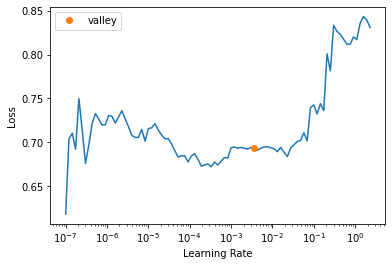

In [ ]:
train_learners(learners)

In [ ]:
# learners["raw_audio"].get_data_loaders()
# learners["raw_audio"].data_loaders.__dict__
# len(learners["raw_audio"].data_loaders.train_ds.indices)
# len(learners["raw_audio"].data_loaders.valid_ds.indices)

229

In [ ]:
%debug

> /usr/local/lib/python3.8/dist-packages/fastai/callback/schedule.py(291)lr_find()
    289 def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    290     "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
--> 291     n_epoch = num_it//len(self.dls.train) + 1
    292     cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    293     with self.no_logging(): self.fit(n_epoch, cbs=cb)

ipdb> type(self.dls.train)
<class 'fastai.data.load.DataLoader'>
ipdb> len(self.dls.train)
*** TypeError: 'float' object cannot be interpreted as an integer
ipdb> self.dls..n
*** SyntaxError: invalid syntax
ipdb> self.dls.n
918
ipdb> self.dls.bs
4.0
ipdb> q


# Ensemble Learner

In [ ]:
from sklearn.metrics import balanced_accuracy_score

class EnsembleChordLearner():
  def __init__(self, learners):
    self.learners = learners

  # https://forums.fast.ai/t/solved-not-splitting-datablock/84759/4
  
  def nosplit(self, o): return L(int(i) for i in range(len(o))), L()

  def get_file_name(self, idx, dl):
    tbr = ["_chroma", "_spec", "_wave", "_epcp", "_spec", "_stft", ".png", ".wav"]
    filename = Path(str(dl.items[idx])).name

    for i in tbr:
      filename.replace(tbr, "")
    
    return filename;

  def eval(self, strategy="avg"):
    # https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/ for getting weighted optimal
    strategies = ["avg", "weighted_sum"]

    preds = targets = []

    pred_dict = {}

    if strategy in strategies:
      
      for learner in learners.values():
        if learner.type == "raw_audio":
            dataloader = DataBlock(
            blocks=(TSTensorBlock, CategoryBlock),
            get_items=get_files,
            get_x=load_audio,
            splitter=self.nosplit,
            get_y=parent_label,
        ).dataloaders(f"{audio_temp}/", bs=learner.batch_size, shuffle=False, drop_last=False)
        else:
          type = next(i[0] for i in IMAGE_TYPES if learner.type in i)
          dataloader = DataBlock(
              blocks=(ImageBlock, CategoryBlock),
              get_items=get_image_files,
              splitter=self.nosplit,
              get_y=parent_label,
              item_tfms=[Resize(192, method='squish')]
          ).dataloaders(f"{IMAGE_ROOT}/{type}/", bs=learner.batch_size, shuffle=False, drop_last=False)

        pred = learner.get_preds(dl=dataloader)

        for idx, val in enumerate(pred[1]):
          name = self.get_file_name(idx, dataloader)

          if pred_dict[name]["label"] and pred_dict[name]["label"] != val:
            raise Exception(f"The files could not be correctly labelled")
          else:
            pred_dict[file].update({"label" : val})
            if len(pred_dict[file]["preds"]) > 0:
              # all predictions for this learner is pred[0]
              pred_dict[file]["preds"].append(pred[0])
            else:
              pred_dict[file]["preds"] = pred[0]
        
        files = pred_dict.keys()

      if strategy == "avg":
        
        avg_probs = []
        targets = []

        classifier = lambda x : int(x[0] < x[1])

        for file in files:
          
          avg_probs.append(np.mean(file["preds"], axis = 0))
          
          targets.append(file["label"])

        
        avg_preds = [classifier(i) for i in avg_probs]
        
        return balanced_accuracy_score(targets, avg_preds)

      elif strategy == "weighted_sum":

        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression()
        X = []
        y = []
        for file in files:
          X.append([preds for preds in file["preds"]])
          y.append(file["label"]) 

        classifier.fit(X, y)

        return balanced_accuracy_score(y, classifier.predict(X))


In [ ]:
ensemble = EnsembleChordLearner(learners=list(learners.values())[:2])

In [ ]:
ensemble.eval()

AttributeError: ignored

In [ ]:
%debug

> <ipython-input-41-4d8128c0a1e4>(44)eval()
     42                 get_y=parent_label,
     43                 item_tfms=[Resize(192, method='squish')]
---> 44             ).dataloaders(f"{IMAGE_ROOT}/{types[0]}/", bs=self.batch_size, shuffle=False, drop_last=False)
     45 
     46           pred = learner.get_preds()

ipdb> types
<module 'types' from '/usr/lib/python3.8/types.py'>
ipdb> q


## Export Model

In [ ]:
def export_models(model_name, wave_learner, spec_learner):
  wave_learner.export(fname=f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/export_wave_{model_name}.pkl")
  spec_learner.export(fname=f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/export_spec_{model_name}.pkl")
  path = Path(f"/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/")
  path.ls(file_exts='.pkl')

## Test Model on New Data

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1"
spec_learner = load_learner(f"{MODEL_DIR}/export_spec.pkl")
wave_learner = load_learner(f"{MODEL_DIR}/export_wave.pkl")

In [ ]:
def get_ensemble_pred(spec, wave):
  spec_probs = spec_learner.predict(spec)[2].numpy()
  wave_probs = wave_learner.predict(wave)[2].numpy()
  probs = np.mean([spec_probs, wave_probs], axis = 0)

  return ('Major', 0, probs) if probs[0] > probs[1] else ('Minor', 1, probs)

In [ ]:
def test_pred(file, dest, true_label):
  spec_path = save_mel_spectrogram(str(file), f"{dest}/Images/Spectrogram/{true_label}/{file.name}")
  wave_path = save_waveform(str(file), f"{dest}/Images/Waveform/{true_label}/{file.name}")

  spec, wave = PILImage.create(spec_path), PILImage.create(wave_path)

  result = get_ensemble_pred(spec, wave)

  # comparing label to prediction
  
  # positive is major, negative is minor
  if result[0].lower() == "major":
    return "TP" if true_label.lower() == "major" else "FP"
  else:
    return "TN" if true_label.lower() == "minor" else "FN"

In [ ]:
from glob import iglob
from tqdm.notebook import tqdm

TEST_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests"

In [ ]:
def do_test_piano_triads():

  # Dataset available at https://www.kaggle.com/datasets/davidbroberts/piano-triads-wavset
  DATASET = "piano_triads"
  
  files = list(iglob(f"{TEST_DIR}/{DATASET}/*_maj_*.wav")) + list(iglob(f"{TEST_DIR}/{DATASET}/*_min_*.wav"))

  bs_dict = {
      "TP": 0,
      "FP": 0,
      "TN": 0,
      "FN": 0,
  }

  for file in tqdm(files):
    
    label = "major" if file.find("maj") != -1 else "minor"

    file = Path(file)
    
    obs = test_pred(file, TEST_DIR, label)

    bs_dict[obs] += 1

  sensitivity = bs_dict["TP"] / (bs_dict["TP"] + bs_dict["FN"])
  specificity = bs_dict["TN"] / (bs_dict["TN"] + bs_dict["FP"])

  
  accuracy = (bs_dict["TP"] + bs_dict["TN"])/len(files) 
  balanced_accuracy = (sensitivity + specificity)/2

  print(f"Accuracy: {accuracy}")
  print(f"Balanced Accuracy: {balanced_accuracy}")

In [ ]:
do_test_piano_triads()

  0%|          | 0/288 [00:00<?, ?it/s]

Accuracy: 0.5034722222222222
Balanced Accuracy: 0.5034722222222222


## Retrain Model on New Data
Model B

In [ ]:
specs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{TEST_DIR}/Images/Spectrogram/", bs=32)

waves = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{TEST_DIR}/Images/Waveform/", bs=32)

wave_learner = vision_learner(waves, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner = vision_learner(specs, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner.fine_tune(5)
wave_learner.fine_tune(5)

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.545441,1.145424,0.490764,00:09


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.098240,1.116466,0.504926,00:07
1,0.940801,1.332871,0.472906,00:07
2,0.861636,1.099235,0.509852,00:07
3,0.787804,1.185981,0.457512,00:07
4,0.707076,1.212473,0.474754,00:07


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.380859,1.972611,0.500616,00:04


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.004729,0.935897,0.436576,00:07
1,0.925631,0.702593,0.664409,00:08
2,0.843441,0.813344,0.580665,00:08
3,0.755619,0.801054,0.578818,00:08
4,0.717281,0.787455,0.579433,00:08


In [ ]:
export_models("model_b", wave_learner, spec_learner)

# Test New Model on Old Data

In [ ]:
TEST_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Images"

def do_test_musical_instrument_chord_classification():

  def test_pred(spec_path, wave_path, true_label):
    spec, wave = PILImage.create(spec_path), PILImage.create(wave_path)

    result = get_ensemble_pred(spec, wave)
    # return ('Major', 0, probs) if probs[0] > probs[1] else ('Minor', 1, probs)

    # comparing label to prediction
    
    # positive is major, negative is minor
    if result[0].lower() == "major":
      return "TP" if true_label.lower() == "major" else "FP"
    else:
      return "TN" if true_label.lower() == "minor" else "FN"

  spec_files = list(iglob(f"{TEST_DIR}/Spectrogram/**/*.png"))

  bs_dict = {
      "TP": 0,
      "FP": 0,
      "TN": 0,
      "FN": 0,
  }

  for spec_file in tqdm(spec_files):
    
    label = "major" if spec_file.lower().find("maj") != -1 else "minor"

    wave_file = spec_file.replace(f"/Spectrogram/", "/Waveform/").replace("_spec.png", "_wave.png")

    obs = test_pred(spec_file, wave_file, label)

    bs_dict[obs] += 1

  sensitivity = bs_dict["TP"] / (bs_dict["TP"] + bs_dict["FN"])
  specificity = bs_dict["TN"] / (bs_dict["TN"] + bs_dict["FP"])

  
  accuracy = (bs_dict["TP"] + bs_dict["TN"])/len(spec_files)
  balanced_accuracy = (sensitivity + specificity)/2

  print(f"Accuracy: {accuracy}")
  print(f"Balanced Accuracy: {balanced_accuracy}")

In [ ]:
do_test_musical_instrument_chord_classification()
# Does really badly predicting negativpositive cases in the other set

  0%|          | 0/859 [00:00<?, ?it/s]

Accuracy: 0.580908032596042
Balanced Accuracy: 0.49943921791824303


In [ ]:
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/major"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/minor"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/major"
! mkdir -p "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/minor"

In [ ]:
dirs = ["/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Tests/Images", "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/Images"]

types = ["major", "minor"]

for dir in dirs:
  for t in types:
    ! cp -r "{dir}/Spectrogram/{t}/." "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/spectrogram/{t}"
    ! cp -r "{dir}/Waveform/{t}/." "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images/waveform/{t}"

In [ ]:
# Clean Env

# !rm -r /content/Audio_Files
# !rm -r /content/Images

# Joint Training#
Model C

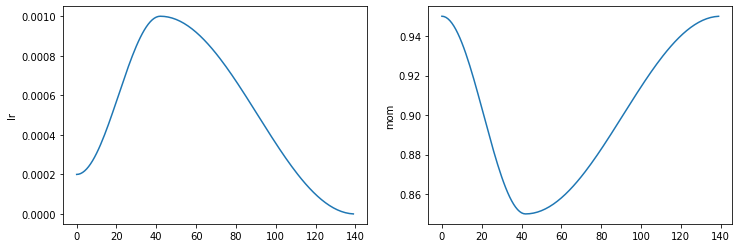

In [ ]:
spec_learner.recorder.plot_sched()

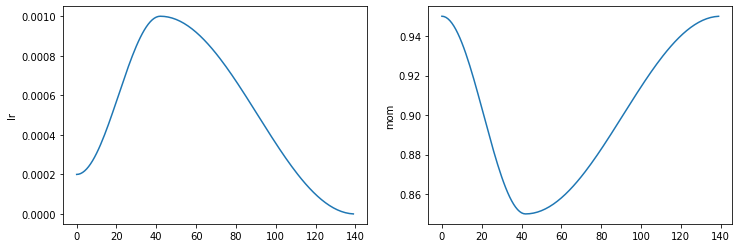

In [ ]:
wave_learner.recorder.plot_sched()

In [ ]:
JOINT_DIR = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Training/Fast.ai/Lesson_1/joint_images"

epochs = 5

specs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{JOINT_DIR}/spectrogram/", bs=32)

waves = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(f"{JOINT_DIR}/waveform/", bs=32)

wave_learner = vision_learner(waves, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner = vision_learner(specs, "convnext_small_in22k", metrics=BalancedAccuracy())
spec_learner.fine_tune(epochs)
wave_learner.fine_tune(epochs)

epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.215849,0.927803,0.605370,00:18


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.919559,0.787091,0.632105,00:30
1,0.909991,1.114704,0.585683,00:29
2,0.835629,0.648779,0.681937,00:29
3,0.721952,0.626523,0.727593,00:29
4,0.621450,0.639259,0.726444,00:29


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,1.279205,0.974863,0.646277,00:17


epoch,train_loss,valid_loss,balanced_accuracy_score,time
0,0.939979,0.787415,0.590777,00:29
1,0.906607,0.908084,0.600046,00:29
2,0.822325,0.754828,0.695534,00:30
3,0.740319,0.656278,0.676115,00:30
4,0.678142,0.628854,0.691934,00:29
